Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [82]:
import numpy as np
import time
import copy
import math
from typing import Callable
import matplotlib.pyplot as plt

In [83]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [84]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [85]:
CONSTRAINTS

array([[231, 309],
       [139, 216],
       [244,  40]], dtype=int32)

## TEST PROBLEMS

In [86]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [87]:
from dataclasses import dataclass


@dataclass
class Solution:
    knapsacks: list[set[int]]
    total_value: int

    def get_items_left(self) -> set[int]:
        items_left = set(range(NUM_ITEMS))
        for ks in self.knapsacks:
            items_left -= ks
        return items_left

In [88]:
def find_first_solution(
    knapsacks: list[set[int]] = None,
) -> Solution:
    if knapsacks is None:
        knapsacks = [set() for _ in range(NUM_KNAPSACKS)]

    running_totals = np.zeros((NUM_KNAPSACKS, NUM_DIMENSIONS), dtype=int)
    total_value = 0

    # We build a simple probability distribution that favors items with higher value-to-weight ratios.
    nudged_probs = np.array(
        [
            1e-3 + np.log(VALUES[i] + 1) - (np.log((WEIGHTS[i] + 1)).sum())
            for i in range(NUM_ITEMS)
        ]
    )

    free_items = set(range(NUM_ITEMS))
    for ks in knapsacks:
        free_items -= ks

    while len(free_items) > 0:
        probs = nudged_probs[list(free_items)]
        probs = probs / probs.sum()
        item = rng.choice(list(free_items), p=probs)

        # Calculate availability after adding the item to each knapsack
        availability_after = CONSTRAINTS - (running_totals + WEIGHTS[item])
        # print((availability_after / CONSTRAINTS).shape)
        # Find knapsacks that can actually accommodate the item
        available_knapsacks = np.where((availability_after >= 0).all(axis=1))[0]
        # print(available_knapsacks)
        # If no knapsack can accommodate the item, skip it
        if len(available_knapsacks) == 0:
            # This item cannot be added to any knapsack (we may be in a local optimum)
            free_items.remove(item)
            continue

        if len(available_knapsacks) == 1:
            knapsack_i = available_knapsacks[0]

        else:
            balance_after = (
                CONSTRAINTS[available_knapsacks]
                - availability_after[available_knapsacks]
            )
            balance_after = balance_after.max(axis=1) - balance_after.min(axis=1)
            nudged_probs2 = 1 / (balance_after + 4)
            nudged_probs2 = nudged_probs2 / nudged_probs2.sum()
            # print(balance_after, balance_after.shape)
            # Select the knapsack that will have the most balanced load between the dimensions of constraint after adding the item
            knapsack_i = available_knapsacks[balance_after.argmin()]
            # knapsack_i = rng.choice(available_knapsacks, p=nudged_probs2)

        knapsacks[knapsack_i].add(item)
        free_items.remove(item)
        running_totals[knapsack_i] += WEIGHTS[item]
        total_value += VALUES[item]

    return Solution(knapsacks=knapsacks, total_value=total_value)

In [89]:
first_solution = find_first_solution()
print(first_solution.total_value)

1020


In [90]:
def benchmark_solution(
    solution_factory: Callable[[], Solution], n_runs: int = 10
) -> Solution:
    start_time = time.time()

    runs_points = np.zeros(n_runs)
    best_knapsacks: list[set[int]] = []
    best_value = 0

    for run_i in range(n_runs):
        solution = solution_factory()
        total_value = solution.total_value

        runs_points[run_i] = total_value
        if total_value > best_value:
            best_value = total_value
            best_knapsacks = solution.knapsacks

    end_time = time.time()
    avg_time = (end_time - start_time) / n_runs

    print("Best total value found:", max(runs_points))
    # print("Best knapsacks found:", best_knapsacks)

    print(f"Statistics over runs (n = {n_runs}):")
    print(f"  Min: {runs_points.min():.2f}")
    print(f"  Max: {runs_points.max():.2f}")
    print(f"  Mean: {runs_points.mean():.2f}")
    print(f"  Std: {runs_points.std():.2f}")
    print(f"Elapsed time: {(avg_time):.4f} seconds")

    return Solution(knapsacks=best_knapsacks, total_value=best_value)

In [91]:
benchmarked_solution = benchmark_solution(find_first_solution, n_runs=10)

Best total value found: 1065.0
Statistics over runs (n = 10):
  Min: 926.00
  Max: 1065.00
  Mean: 1001.70
  Std: 45.98
Elapsed time: 0.0018 seconds


In [92]:
def tweak_solution(original: Solution) -> Solution:
    # Shallow copy knapsacks (sets) and build an item->knapsack map for O(1) lookups
    new_knapsacks = [set(s) for s in original.knapsacks]
    item_to_knapsack = np.full(NUM_ITEMS, -1, dtype=int)
    for k, ks in enumerate(new_knapsacks):
        for it in ks:
            item_to_knapsack[it] = k

    # Compute running_totals efficiently per knapsack
    running_totals = np.zeros((NUM_KNAPSACKS, NUM_DIMENSIONS), dtype=int)
    for k, ks in enumerate(new_knapsacks):
        if ks:
            running_totals[k] = WEIGHTS[list(ks)].sum(axis=0)

    total_value = int(original.total_value)

    # Decide how many items to tweak
    n_tweaks = int(rng.integers(1, max(2, NUM_ITEMS // 20)))

    for _ in range(n_tweaks):
        item = int(rng.integers(0, NUM_ITEMS))
        current = int(item_to_knapsack[item])

        # Remove from current knapsack if present (update map and totals incrementally)
        if current != -1:
            new_knapsacks[current].remove(item)
            running_totals[current] -= WEIGHTS[item]
            total_value -= int(VALUES[item])
            item_to_knapsack[item] = -1

        # Find candidate knapsacks that can accept the item (vectorized check)
        # compute needed = running_totals + WEIGHTS[item] and compare to CONSTRAINTS
        needed = running_totals + WEIGHTS[item]  # shape (K, D)
        feasible = np.all(needed <= CONSTRAINTS, axis=1)
        # exclude current (already removed) from candidates
        feasible_indices = np.where(feasible)[0].tolist()
        if current in feasible_indices:
            feasible_indices.remove(current)

        if feasible_indices:
            chosen = int(rng.choice(feasible_indices))
            new_knapsacks[chosen].add(item)
            running_totals[chosen] += WEIGHTS[item]
            total_value += int(VALUES[item])
            item_to_knapsack[item] = chosen

    return Solution(knapsacks=new_knapsacks, total_value=total_value)


In [93]:
tweak_solution(benchmarked_solution).total_value

1013

In [94]:
def benchmark_tweak(
    original: Solution,
    tweak_function: Callable[[Solution], Solution],
    n_runs: int = 10,
) -> Solution:
    start_time = time.time()

    runs_points = np.zeros(n_runs)
    best_solution = original

    for run_i in range(n_runs):
        solution = tweak_function(original)

        runs_points[run_i] = solution.total_value
        if solution.total_value > best_solution.total_value:
            best_solution = solution

    end_time = time.time()
    avg_time = (end_time - start_time) / n_runs

    print("Best total value found after tweak:", max(runs_points))
    # print("Best knapsacks found:", best_knapsacks)

    print(f"Statistics over tweak runs (n = {n_runs}):")
    print(f"  Min: {runs_points.min():.2f}")
    print(f"  Max: {runs_points.max():.2f}")
    print(f"  Mean: {runs_points.mean():.2f}")
    print(f"  Std: {runs_points.std():.2f}")
    print(f"Elapsed time: {(avg_time):.4f} seconds")

    return best_solution

In [95]:
tweaked_solution = benchmark_tweak(benchmarked_solution, tweak_solution, n_runs=10)

Best total value found after tweak: 1053.0
Statistics over tweak runs (n = 10):
  Min: 980.00
  Max: 1053.00
  Mean: 1013.90
  Std: 18.64
Elapsed time: 0.0001 seconds


In [96]:
tweaked_solution = benchmark_tweak(tweaked_solution, tweak_solution, n_runs=100)

Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1022.20
  Std: 31.10
Elapsed time: 0.0001 seconds


In [97]:
from tqdm import tqdm

In [98]:
for _ in tqdm(range(10)):
    tweaked_solution = benchmark_tweak(tweaked_solution, tweak_solution, n_runs=100)

  0%|          | 0/10 [00:00<?, ?it/s]

Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1018.46
  Std: 32.58
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1019.09
  Std: 31.83
Elapsed time: 0.0000 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1025.19
  Std: 29.18
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1019.78
  Std: 32.42
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1025.07
  Std: 29.65
Elapsed time: 0.0000 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1024.47
  Std: 33.22
Elapsed time: 0.0001 

100%|██████████| 10/10 [00:00<00:00, 162.29it/s]

Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1022.08
  Std: 31.85
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1023.65
  Std: 31.51
Elapsed time: 0.0001 seconds


## TEST PROBLEMS

In [99]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

Best total value found: 1065.0
Statistics over runs (n = 100):
  Min: 843.00
  Max: 1065.00
  Mean: 997.33
  Std: 54.76
Elapsed time: 0.0016 seconds


100%|██████████| 10/10 [00:00<00:00, 183.78it/s]

Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1022.66
  Std: 29.35
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1022.72
  Std: 32.61
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1023.22
  Std: 32.54
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1017.91
  Std: 34.86
Elapsed time: 0.0000 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1024.25
  Std: 33.03
Elapsed time: 0.0001 seconds
Best total value found after tweak: 1065.0
Statistics over tweak runs (n = 100):
  Min: 968.00
  Max: 1065.00
  Mean: 1025.08
  Std: 32.68
Elapsed time: 0.0000 

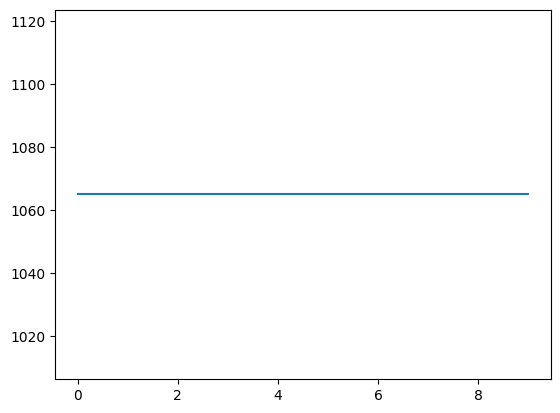

In [100]:
first_solution = benchmark_solution(find_first_solution, n_runs=100)
first_solution.total_value
tweaked_solution = first_solution
scores = []

for _ in tqdm(range(10)):
    tweaked_solution = benchmark_tweak(tweaked_solution, tweak_solution, n_runs=100)
    scores.append(tweaked_solution.total_value)

print(tweaked_solution.total_value)
plt.plot(scores)
plt.show()

In [101]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

Best total value found: 39355.0
Statistics over runs (n = 1000):
  Min: 27817.00
  Max: 39355.00
  Mean: 34308.07
  Std: 1755.80
Elapsed time: 0.0060 seconds


  2%|▏         | 4/250 [00:00<00:07, 31.88it/s]

Best total value found after tweak: 40004.0
Statistics over tweak runs (n = 250):
  Min: 37041.00
  Max: 40004.00
  Mean: 38694.06
  Std: 498.42
Elapsed time: 0.0001 seconds
Best total value found after tweak: 40922.0
Statistics over tweak runs (n = 250):
  Min: 37479.00
  Max: 40922.00
  Mean: 39355.14
  Std: 618.43
Elapsed time: 0.0001 seconds
Best total value found after tweak: 41872.0
Statistics over tweak runs (n = 250):
  Min: 38586.00
  Max: 41872.00
  Mean: 40355.85
  Std: 682.64
Elapsed time: 0.0001 seconds
Best total value found after tweak: 42189.0
Statistics over tweak runs (n = 250):
  Min: 38992.00
  Max: 42189.00
  Mean: 40987.52
  Std: 617.38
Elapsed time: 0.0001 seconds
Best total value found after tweak: 42189.0
Statistics over tweak runs (n = 250):
  Min: 39774.00
  Max: 42189.00
  Mean: 41292.75
  Std: 582.99
Elapsed time: 0.0001 seconds
Best total value found after tweak: 42429.0
Statistics over tweak runs (n = 250):
  Min: 38705.00
  Max: 42429.00
  Mean: 41340.13

  5%|▍         | 12/250 [00:00<00:07, 31.43it/s]

Best total value found after tweak: 43133.0
Statistics over tweak runs (n = 250):
  Min: 40235.00
  Max: 43133.00
  Mean: 42123.86
  Std: 579.81
Elapsed time: 0.0001 seconds
Best total value found after tweak: 43723.0
Statistics over tweak runs (n = 250):
  Min: 40548.00
  Max: 43723.00
  Mean: 42344.08
  Std: 592.82
Elapsed time: 0.0001 seconds
Best total value found after tweak: 43786.0
Statistics over tweak runs (n = 250):
  Min: 41022.00
  Max: 43786.00
  Mean: 42964.61
  Std: 581.00
Elapsed time: 0.0001 seconds
Best total value found after tweak: 44350.0
Statistics over tweak runs (n = 250):
  Min: 41367.00
  Max: 44350.00
  Mean: 43025.83
  Std: 578.59
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45128.0
Statistics over tweak runs (n = 250):
  Min: 41066.00
  Max: 45128.00
  Mean: 43522.64
  Std: 640.31
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45128.0
Statistics over tweak runs (n = 250):
  Min: 42359.00
  Max: 45128.00
  Mean: 44193.64

  8%|▊         | 20/250 [00:00<00:07, 31.52it/s]

Best total value found after tweak: 45590.0
Statistics over tweak runs (n = 250):
  Min: 43042.00
  Max: 45590.00
  Mean: 44701.03
  Std: 610.63
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45590.0
Statistics over tweak runs (n = 250):
  Min: 42795.00
  Max: 45590.00
  Mean: 44675.74
  Std: 599.55
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45590.0
Statistics over tweak runs (n = 250):
  Min: 42126.00
  Max: 45590.00
  Mean: 44650.50
  Std: 629.68
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45590.0
Statistics over tweak runs (n = 250):
  Min: 42792.00
  Max: 45590.00
  Mean: 44704.87
  Std: 587.56
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45590.0
Statistics over tweak runs (n = 250):
  Min: 43205.00
  Max: 45590.00
  Mean: 44753.46
  Std: 563.35
Elapsed time: 0.0001 seconds
Best total value found after tweak: 45771.0
Statistics over tweak runs (n = 250):
  Min: 42232.00
  Max: 45771.00
  Mean: 44747.66

 10%|▉         | 24/250 [00:00<00:07, 31.19it/s]

Best total value found after tweak: 45854.0
Statistics over tweak runs (n = 250):
  Min: 43092.00
  Max: 45854.00
  Mean: 44923.45
  Std: 612.36
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43240.00
  Max: 46304.00
  Mean: 44984.26
  Std: 595.21
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43714.00
  Max: 46304.00
  Mean: 45375.12
  Std: 614.77
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43275.00
  Max: 46304.00
  Mean: 45399.95
  Std: 599.27
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43197.00
  Max: 46304.00
  Mean: 45358.26
  Std: 591.26
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43322.00
  Max: 46304.00
  Mean: 45443.15

 11%|█         | 28/250 [00:00<00:07, 31.28it/s]

Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43191.00
  Max: 46304.00
  Mean: 45367.20
  Std: 636.81
Elapsed time: 0.0001 seconds


 13%|█▎        | 32/250 [00:01<00:07, 31.11it/s]

Best total value found after tweak: 46304.0
Statistics over tweak runs (n = 250):
  Min: 43100.00
  Max: 46304.00
  Mean: 45423.02
  Std: 633.90
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46309.0
Statistics over tweak runs (n = 250):
  Min: 43783.00
  Max: 46309.00
  Mean: 45446.86
  Std: 590.22
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46581.0
Statistics over tweak runs (n = 250):
  Min: 43457.00
  Max: 46581.00
  Mean: 45483.83
  Std: 577.64
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46581.0
Statistics over tweak runs (n = 250):
  Min: 43831.00
  Max: 46581.00
  Mean: 45693.40
  Std: 621.66
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46687.0
Statistics over tweak runs (n = 250):
  Min: 44011.00
  Max: 46687.00
  Mean: 45694.41
  Std: 597.65
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46687.0
Statistics over tweak runs (n = 250):
  Min: 44122.00
  Max: 46687.00
  Mean: 45842.35

 16%|█▌        | 40/250 [00:01<00:06, 31.33it/s]

Best total value found after tweak: 46812.0
Statistics over tweak runs (n = 250):
  Min: 44354.00
  Max: 46812.00
  Mean: 45856.68
  Std: 579.78
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46812.0
Statistics over tweak runs (n = 250):
  Min: 44152.00
  Max: 46812.00
  Mean: 45911.45
  Std: 601.00
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46812.0
Statistics over tweak runs (n = 250):
  Min: 44197.00
  Max: 46812.00
  Mean: 45865.79
  Std: 581.96
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46852.0
Statistics over tweak runs (n = 250):
  Min: 44239.00
  Max: 46852.00
  Mean: 45898.63
  Std: 645.21
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46852.0
Statistics over tweak runs (n = 250):
  Min: 43860.00
  Max: 46852.00
  Mean: 45952.76
  Std: 603.24
Elapsed time: 0.0001 seconds
Best total value found after tweak: 46852.0
Statistics over tweak runs (n = 250):
  Min: 44162.00
  Max: 46852.00
  Mean: 45927.15

 19%|█▉        | 48/250 [00:01<00:06, 31.31it/s]

Best total value found after tweak: 47052.0
Statistics over tweak runs (n = 250):
  Min: 44332.00
  Max: 47052.00
  Mean: 46129.78
  Std: 607.77
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47065.0
Statistics over tweak runs (n = 250):
  Min: 44087.00
  Max: 47065.00
  Mean: 46089.46
  Std: 663.42
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47065.0
Statistics over tweak runs (n = 250):
  Min: 44014.00
  Max: 47065.00
  Mean: 46060.43
  Std: 590.22
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47065.0
Statistics over tweak runs (n = 250):
  Min: 43808.00
  Max: 47065.00
  Mean: 46145.58
  Std: 617.68
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47065.0
Statistics over tweak runs (n = 250):
  Min: 43919.00
  Max: 47065.00
  Mean: 46124.37
  Std: 629.60
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47074.0
Statistics over tweak runs (n = 250):
  Min: 44428.00
  Max: 47074.00
  Mean: 46176.83

 21%|██        | 52/250 [00:01<00:06, 31.32it/s]

Best total value found after tweak: 47074.0
Statistics over tweak runs (n = 250):
  Min: 44460.00
  Max: 47074.00
  Mean: 46178.04
  Std: 617.70
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47074.0
Statistics over tweak runs (n = 250):
  Min: 44046.00
  Max: 47074.00
  Mean: 46196.67
  Std: 600.37
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44028.00
  Max: 47161.00
  Mean: 46180.66
  Std: 622.71
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44143.00
  Max: 47161.00
  Mean: 46234.98
  Std: 613.47
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44190.00
  Max: 47161.00
  Mean: 46163.72
  Std: 630.14
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 43972.00
  Max: 47161.00
  Mean: 46280.79

 22%|██▏       | 56/250 [00:01<00:06, 31.65it/s]

Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44236.00
  Max: 47161.00
  Mean: 46291.24
  Std: 611.81
Elapsed time: 0.0001 seconds


 24%|██▍       | 60/250 [00:01<00:06, 31.62it/s]

Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 43932.00
  Max: 47161.00
  Mean: 46244.62
  Std: 606.37
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44540.00
  Max: 47161.00
  Mean: 46202.22
  Std: 633.82
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 43994.00
  Max: 47161.00
  Mean: 46210.84
  Std: 624.85
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44718.00
  Max: 47161.00
  Mean: 46278.44
  Std: 598.90
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47161.0
Statistics over tweak runs (n = 250):
  Min: 44142.00
  Max: 47161.00
  Mean: 46187.85
  Std: 646.30
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47194.0
Statistics over tweak runs (n = 250):
  Min: 44397.00
  Max: 47194.00
  Mean: 46214.88

 27%|██▋       | 68/250 [00:02<00:05, 31.57it/s]

Best total value found after tweak: 47194.0
Statistics over tweak runs (n = 250):
  Min: 44277.00
  Max: 47194.00
  Mean: 46229.64
  Std: 618.05
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47194.0
Statistics over tweak runs (n = 250):
  Min: 43984.00
  Max: 47194.00
  Mean: 46276.12
  Std: 593.08
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47194.0
Statistics over tweak runs (n = 250):
  Min: 44802.00
  Max: 47194.00
  Mean: 46297.92
  Std: 587.69
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47194.0
Statistics over tweak runs (n = 250):
  Min: 44520.00
  Max: 47194.00
  Mean: 46260.72
  Std: 611.64
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47194.0
Statistics over tweak runs (n = 250):
  Min: 44222.00
  Max: 47194.00
  Mean: 46235.67
  Std: 616.15
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44449.00
  Max: 47436.00
  Mean: 46202.90

 29%|██▉       | 72/250 [00:02<00:05, 31.02it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44543.00
  Max: 47436.00
  Mean: 46457.63
  Std: 664.04
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44680.00
  Max: 47436.00
  Mean: 46504.96
  Std: 634.33
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44372.00
  Max: 47436.00
  Mean: 46456.36
  Std: 651.46
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44807.00
  Max: 47436.00
  Mean: 46455.32
  Std: 597.62
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44217.00
  Max: 47436.00
  Mean: 46476.10
  Std: 641.74
Elapsed time: 0.0001 seconds


 30%|███       | 76/250 [00:02<00:05, 30.01it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44955.00
  Max: 47436.00
  Mean: 46461.54
  Std: 594.99
Elapsed time: 0.0001 seconds


 32%|███▏      | 80/250 [00:02<00:05, 29.88it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44852.00
  Max: 47436.00
  Mean: 46465.32
  Std: 626.79
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44901.00
  Max: 47436.00
  Mean: 46491.16
  Std: 613.47
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44306.00
  Max: 47436.00
  Mean: 46494.04
  Std: 629.77
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44391.00
  Max: 47436.00
  Mean: 46490.18
  Std: 643.05
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44846.00
  Max: 47436.00
  Mean: 46558.66
  Std: 595.30
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44603.00
  Max: 47436.00
  Mean: 46519.44

 35%|███▌      | 88/250 [00:02<00:05, 30.81it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44843.00
  Max: 47436.00
  Mean: 46516.85
  Std: 593.61
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44853.00
  Max: 47436.00
  Mean: 46520.30
  Std: 579.67
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44853.00
  Max: 47436.00
  Mean: 46491.05
  Std: 594.30
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44739.00
  Max: 47436.00
  Mean: 46507.40
  Std: 615.02
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44744.00
  Max: 47436.00
  Mean: 46456.89
  Std: 602.82
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44609.00
  Max: 47436.00
  Mean: 46530.96

 37%|███▋      | 92/250 [00:02<00:05, 30.12it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44877.00
  Max: 47436.00
  Mean: 46535.14
  Std: 588.23
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44131.00
  Max: 47436.00
  Mean: 46480.45
  Std: 643.56
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44310.00
  Max: 47436.00
  Mean: 46515.44
  Std: 586.26
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44498.00
  Max: 47436.00
  Mean: 46476.63
  Std: 601.39
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44297.00
  Max: 47436.00
  Mean: 46529.31
  Std: 624.32
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44789.00
  Max: 47436.00
  Mean: 46491.56

 40%|████      | 100/250 [00:03<00:05, 29.25it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 43808.00
  Max: 47436.00
  Mean: 46453.88
  Std: 684.08
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44744.00
  Max: 47436.00
  Mean: 46437.62
  Std: 605.60
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44369.00
  Max: 47436.00
  Mean: 46479.97
  Std: 669.69
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44673.00
  Max: 47436.00
  Mean: 46558.36
  Std: 588.01
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44888.00
  Max: 47436.00
  Mean: 46481.50
  Std: 593.81
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44691.00
  Max: 47436.00
  Mean: 46513.45

 43%|████▎     | 108/250 [00:03<00:04, 29.51it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44733.00
  Max: 47436.00
  Mean: 46529.10
  Std: 634.25
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44171.00
  Max: 47436.00
  Mean: 46482.80
  Std: 671.68
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44870.00
  Max: 47436.00
  Mean: 46508.01
  Std: 607.67
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44318.00
  Max: 47436.00
  Mean: 46383.07
  Std: 633.39
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44317.00
  Max: 47436.00
  Mean: 46431.26
  Std: 633.20
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44392.00
  Max: 47436.00
  Mean: 46461.09

 45%|████▍     | 112/250 [00:03<00:04, 29.95it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44402.00
  Max: 47436.00
  Mean: 46385.92
  Std: 661.56
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44254.00
  Max: 47436.00
  Mean: 46515.88
  Std: 640.79
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44810.00
  Max: 47436.00
  Mean: 46503.26
  Std: 641.47
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44592.00
  Max: 47436.00
  Mean: 46474.64
  Std: 649.09
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44763.00
  Max: 47436.00
  Mean: 46474.15
  Std: 620.89
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44434.00
  Max: 47436.00
  Mean: 46474.77

 46%|████▋     | 116/250 [00:03<00:04, 30.49it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44645.00
  Max: 47436.00
  Mean: 46423.52
  Std: 678.61
Elapsed time: 0.0001 seconds


 48%|████▊     | 120/250 [00:03<00:04, 30.54it/s]

Best total value found after tweak: 47436.0
Statistics over tweak runs (n = 250):
  Min: 44100.00
  Max: 47436.00
  Mean: 46427.72
  Std: 626.97
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44458.00
  Max: 47481.00
  Mean: 46460.15
  Std: 660.98
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44839.00
  Max: 47481.00
  Mean: 46547.60
  Std: 632.79
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44807.00
  Max: 47481.00
  Mean: 46522.80
  Std: 603.90
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44823.00
  Max: 47481.00
  Mean: 46573.22
  Std: 588.78
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44600.00
  Max: 47481.00
  Mean: 46514.51

 51%|█████     | 128/250 [00:04<00:03, 30.85it/s]

Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 43824.00
  Max: 47481.00
  Mean: 46539.63
  Std: 664.72
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44620.00
  Max: 47481.00
  Mean: 46541.10
  Std: 562.80
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44619.00
  Max: 47481.00
  Mean: 46510.98
  Std: 637.21
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 45155.00
  Max: 47481.00
  Mean: 46567.90
  Std: 574.84
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44938.00
  Max: 47481.00
  Mean: 46529.75
  Std: 588.07
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44933.00
  Max: 47481.00
  Mean: 46618.24

 53%|█████▎    | 132/250 [00:04<00:03, 30.87it/s]

Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44261.00
  Max: 47481.00
  Mean: 46551.06
  Std: 586.75
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44655.00
  Max: 47481.00
  Mean: 46511.76
  Std: 616.45
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44688.00
  Max: 47481.00
  Mean: 46596.08
  Std: 622.03
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47481.0
Statistics over tweak runs (n = 250):
  Min: 44833.00
  Max: 47481.00
  Mean: 46505.16
  Std: 623.70
Elapsed time: 0.0002 seconds
Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44728.00
  Max: 47563.00
  Mean: 46580.79
  Std: 602.95
Elapsed time: 0.0001 seconds


 54%|█████▍    | 136/250 [00:04<00:03, 30.01it/s]

Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44800.00
  Max: 47563.00
  Mean: 46651.68
  Std: 583.48
Elapsed time: 0.0001 seconds


 56%|█████▌    | 140/250 [00:04<00:03, 30.38it/s]

Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44688.00
  Max: 47563.00
  Mean: 46609.80
  Std: 613.40
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44937.00
  Max: 47563.00
  Mean: 46636.52
  Std: 605.70
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44435.00
  Max: 47563.00
  Mean: 46579.69
  Std: 657.97
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44477.00
  Max: 47563.00
  Mean: 46628.91
  Std: 660.82
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44813.00
  Max: 47563.00
  Mean: 46695.57
  Std: 591.38
Elapsed time: 0.0001 seconds
Best total value found after tweak: 47563.0
Statistics over tweak runs (n = 250):
  Min: 44861.00
  Max: 47563.00
  Mean: 46631.51

 59%|█████▉    | 148/250 [00:04<00:03, 30.85it/s]

Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 44040.00
  Max: 48060.00
  Mean: 46628.58
  Std: 642.46
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45305.00
  Max: 48060.00
  Mean: 47042.00
  Std: 583.24
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 44941.00
  Max: 48060.00
  Mean: 47052.59
  Std: 626.07
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45323.00
  Max: 48060.00
  Mean: 47078.74
  Std: 625.60
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45050.00
  Max: 48060.00
  Mean: 47030.48
  Std: 673.00
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45184.00
  Max: 48060.00
  Mean: 47052.36

 62%|██████▏   | 156/250 [00:05<00:03, 31.23it/s]

Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45567.00
  Max: 48060.00
  Mean: 47076.12
  Std: 651.38
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 44895.00
  Max: 48060.00
  Mean: 47115.77
  Std: 659.31
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45143.00
  Max: 48060.00
  Mean: 47136.52
  Std: 639.71
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 44744.00
  Max: 48060.00
  Mean: 47074.40
  Std: 652.00
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 45220.00
  Max: 48060.00
  Mean: 47062.20
  Std: 643.69
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48060.0
Statistics over tweak runs (n = 250):
  Min: 44760.00
  Max: 48060.00
  Mean: 47040.86

 64%|██████▍   | 160/250 [00:05<00:02, 30.67it/s]

Best total value found after tweak: 48087.0
Statistics over tweak runs (n = 250):
  Min: 45463.00
  Max: 48087.00
  Mean: 47093.19
  Std: 609.88
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48087.0
Statistics over tweak runs (n = 250):
  Min: 45147.00
  Max: 48087.00
  Mean: 47064.32
  Std: 640.43
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48174.0
Statistics over tweak runs (n = 250):
  Min: 45568.00
  Max: 48174.00
  Mean: 47070.63
  Std: 609.00
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 44819.00
  Max: 48401.00
  Mean: 47241.20
  Std: 654.22
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45770.00
  Max: 48401.00
  Mean: 47524.09
  Std: 601.35
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45574.00
  Max: 48401.00
  Mean: 47437.91

 66%|██████▌   | 164/250 [00:05<00:02, 30.07it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 44884.00
  Max: 48401.00
  Mean: 47463.51
  Std: 639.63
Elapsed time: 0.0001 seconds


 67%|██████▋   | 168/250 [00:05<00:02, 30.52it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45548.00
  Max: 48401.00
  Mean: 47426.15
  Std: 637.65
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45128.00
  Max: 48401.00
  Mean: 47377.78
  Std: 669.75
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45258.00
  Max: 48401.00
  Mean: 47381.85
  Std: 617.71
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45076.00
  Max: 48401.00
  Mean: 47385.20
  Std: 613.73
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45456.00
  Max: 48401.00
  Mean: 47421.94
  Std: 607.12
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45323.00
  Max: 48401.00
  Mean: 47464.58

 70%|███████   | 176/250 [00:05<00:02, 31.14it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45608.00
  Max: 48401.00
  Mean: 47386.32
  Std: 614.91
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45498.00
  Max: 48401.00
  Mean: 47436.01
  Std: 631.30
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45683.00
  Max: 48401.00
  Mean: 47461.38
  Std: 545.90
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45391.00
  Max: 48401.00
  Mean: 47401.65
  Std: 637.10
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45159.00
  Max: 48401.00
  Mean: 47382.62
  Std: 624.16
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45390.00
  Max: 48401.00
  Mean: 47402.25

 74%|███████▎  | 184/250 [00:05<00:02, 31.37it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45440.00
  Max: 48401.00
  Mean: 47464.55
  Std: 627.89
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45505.00
  Max: 48401.00
  Mean: 47378.76
  Std: 635.24
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45456.00
  Max: 48401.00
  Mean: 47439.52
  Std: 635.66
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45264.00
  Max: 48401.00
  Mean: 47336.28
  Std: 679.23
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45849.00
  Max: 48401.00
  Mean: 47424.04
  Std: 585.55
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45510.00
  Max: 48401.00
  Mean: 47439.34

 75%|███████▌  | 188/250 [00:06<00:01, 31.47it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45169.00
  Max: 48401.00
  Mean: 47468.12
  Std: 623.11
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45562.00
  Max: 48401.00
  Mean: 47402.78
  Std: 701.60
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45701.00
  Max: 48401.00
  Mean: 47412.30
  Std: 638.64
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45165.00
  Max: 48401.00
  Mean: 47439.30
  Std: 635.05
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45475.00
  Max: 48401.00
  Mean: 47419.78
  Std: 647.16
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45850.00
  Max: 48401.00
  Mean: 47414.32

 77%|███████▋  | 192/250 [00:06<00:01, 31.56it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45594.00
  Max: 48401.00
  Mean: 47399.17
  Std: 617.60
Elapsed time: 0.0001 seconds


 78%|███████▊  | 196/250 [00:06<00:01, 30.39it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45568.00
  Max: 48401.00
  Mean: 47444.26
  Std: 592.13
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45637.00
  Max: 48401.00
  Mean: 47425.02
  Std: 639.06
Elapsed time: 0.0002 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 44939.00
  Max: 48401.00
  Mean: 47373.80
  Std: 675.12
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45531.00
  Max: 48401.00
  Mean: 47367.71
  Std: 621.35
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45461.00
  Max: 48401.00
  Mean: 47438.36
  Std: 623.57
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45335.00
  Max: 48401.00
  Mean: 47487.90

 82%|████████▏ | 204/250 [00:06<00:01, 31.18it/s]

 48401.0
Statistics over tweak runs (n = 250):
  Min: 45851.00
  Max: 48401.00
  Mean: 47463.50
  Std: 591.14
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45241.00
  Max: 48401.00
  Mean: 47373.61
  Std: 663.72
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45609.00
  Max: 48401.00
  Mean: 47385.16
  Std: 606.64
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45684.00
  Max: 48401.00
  Mean: 47405.25
  Std: 625.39
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45129.00
  Max: 48401.00
  Mean: 47440.51
  Std: 621.94
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45092.00
  Max: 48401.00
  Mean: 47459.23
  Std: 636.56
Elapsed time: 0.0001

 85%|████████▍ | 212/250 [00:06<00:01, 31.25it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 44950.00
  Max: 48401.00
  Mean: 47459.84
  Std: 628.65
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45620.00
  Max: 48401.00
  Mean: 47405.59
  Std: 604.92
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45627.00
  Max: 48401.00
  Mean: 47413.76
  Std: 631.74
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45669.00
  Max: 48401.00
  Mean: 47455.98
  Std: 585.34
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45570.00
  Max: 48401.00
  Mean: 47391.96
  Std: 617.61
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45722.00
  Max: 48401.00
  Mean: 47419.18

 86%|████████▋ | 216/250 [00:07<00:01, 31.34it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45409.00
  Max: 48401.00
  Mean: 47459.95
  Std: 606.57
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45510.00
  Max: 48401.00
  Mean: 47481.02
  Std: 630.51
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45536.00
  Max: 48401.00
  Mean: 47462.58
  Std: 620.57
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45483.00
  Max: 48401.00
  Mean: 47349.60
  Std: 615.18
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45051.00
  Max: 48401.00
  Mean: 47481.20
  Std: 643.70
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45550.00
  Max: 48401.00
  Mean: 47373.37

 90%|████████▉ | 224/250 [00:07<00:00, 31.67it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45667.00
  Max: 48401.00
  Mean: 47391.23
  Std: 583.48
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45883.00
  Max: 48401.00
  Mean: 47348.66
  Std: 623.94
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45801.00
  Max: 48401.00
  Mean: 47432.24
  Std: 533.02
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45635.00
  Max: 48401.00
  Mean: 47428.20
  Std: 630.49
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 44860.00
  Max: 48401.00
  Mean: 47403.44
  Std: 656.00
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45398.00
  Max: 48401.00
  Mean: 47471.18

 93%|█████████▎| 232/250 [00:07<00:00, 31.78it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45525.00
  Max: 48401.00
  Mean: 47299.61
  Std: 629.22
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45659.00
  Max: 48401.00
  Mean: 47386.58
  Std: 655.36
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45053.00
  Max: 48401.00
  Mean: 47363.80
  Std: 691.38
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45498.00
  Max: 48401.00
  Mean: 47421.78
  Std: 642.31
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45824.00
  Max: 48401.00
  Mean: 47464.45
  Std: 599.53
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45154.00
  Max: 48401.00
  Mean: 47375.18

 96%|█████████▌| 240/250 [00:07<00:00, 31.12it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45487.00
  Max: 48401.00
  Mean: 47467.96
  Std: 613.46
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45647.00
  Max: 48401.00
  Mean: 47401.07
  Std: 651.39
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45834.00
  Max: 48401.00
  Mean: 47419.83
  Std: 595.53
Elapsed time: 0.0002 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45396.00
  Max: 48401.00
  Mean: 47411.84
  Std: 632.25
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45136.00
  Max: 48401.00
  Mean: 47396.32
  Std: 651.44
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45676.00
  Max: 48401.00
  Mean: 47455.39

 98%|█████████▊| 244/250 [00:07<00:00, 31.33it/s]

Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45642.00
  Max: 48401.00
  Mean: 47508.74
  Std: 625.08
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45630.00
  Max: 48401.00
  Mean: 47465.59
  Std: 605.66
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45095.00
  Max: 48401.00
  Mean: 47411.33
  Std: 604.83
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45300.00
  Max: 48401.00
  Mean: 47381.55
  Std: 633.47
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45168.00
  Max: 48401.00
  Mean: 47406.69
  Std: 608.99
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45534.00
  Max: 48401.00
  Mean: 47389.62

100%|██████████| 250/250 [00:08<00:00, 30.90it/s]


Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45600.00
  Max: 48401.00
  Mean: 47375.30
  Std: 648.38
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45678.00
  Max: 48401.00
  Mean: 47455.69
  Std: 596.62
Elapsed time: 0.0001 seconds
Best total value found after tweak: 48401.0
Statistics over tweak runs (n = 250):
  Min: 45525.00
  Max: 48401.00
  Mean: 47353.75
  Std: 598.06
Elapsed time: 0.0001 seconds
48401


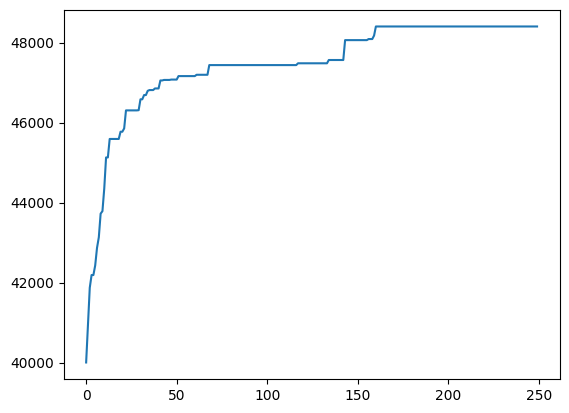

In [102]:
first_solution = benchmark_solution(find_first_solution, n_runs=1000)
first_solution.total_value
tweaked_solution = first_solution
scores = []

for _ in tqdm(range(250)):
    tweaked_solution = benchmark_tweak(tweaked_solution, tweak_solution, n_runs=250)
    scores.append(tweaked_solution.total_value)

print(tweaked_solution.total_value)
plt.plot(scores)
plt.show()

In [103]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10,
    1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS,
    size=(NUM_KNAPSACKS, NUM_DIMENSIONS),
)

Best total value found: 1227842.0
Statistics over runs (n = 10):
  Min: 1188740.00
  Max: 1227842.00
  Mean: 1210450.80
  Std: 11438.30
Elapsed time: 2.0743 seconds


  1%|          | 1/100 [00:00<00:29,  3.38it/s]

Best total value found after tweak: 1245874.0
Statistics over tweak runs (n = 50):
  Min: 1221737.00
  Max: 1245874.00
  Mean: 1230032.80
  Std: 5633.18
Elapsed time: 0.0059 seconds


  2%|▏         | 2/100 [00:00<00:31,  3.11it/s]

Best total value found after tweak: 1278444.0
Statistics over tweak runs (n = 50):
  Min: 1246420.00
  Max: 1278444.00
  Mean: 1258022.78
  Std: 7696.93
Elapsed time: 0.0067 seconds


  3%|▎         | 3/100 [00:00<00:28,  3.35it/s]

Best total value found after tweak: 1298856.0
Statistics over tweak runs (n = 50):
  Min: 1276371.00
  Max: 1298856.00
  Mean: 1285895.06
  Std: 5293.05
Elapsed time: 0.0054 seconds


  4%|▍         | 4/100 [00:01<00:30,  3.11it/s]

Best total value found after tweak: 1320881.0
Statistics over tweak runs (n = 50):
  Min: 1294631.00
  Max: 1320881.00
  Mean: 1307187.42
  Std: 5669.36
Elapsed time: 0.0071 seconds


  5%|▌         | 5/100 [00:01<00:31,  2.99it/s]

Best total value found after tweak: 1341908.0
Statistics over tweak runs (n = 50):
  Min: 1318557.00
  Max: 1341908.00
  Mean: 1329104.72
  Std: 6001.05
Elapsed time: 0.0071 seconds


  6%|▌         | 6/100 [00:01<00:31,  3.03it/s]

Best total value found after tweak: 1364028.0
Statistics over tweak runs (n = 50):
  Min: 1341587.00
  Max: 1364028.00
  Mean: 1350427.74
  Std: 6500.48
Elapsed time: 0.0064 seconds


  7%|▋         | 7/100 [00:02<00:31,  3.00it/s]

Best total value found after tweak: 1383300.0
Statistics over tweak runs (n = 50):
  Min: 1361276.00
  Max: 1383300.00
  Mean: 1371118.46
  Std: 5246.61
Elapsed time: 0.0068 seconds


  8%|▊         | 8/100 [00:02<00:29,  3.13it/s]

Best total value found after tweak: 1398522.0
Statistics over tweak runs (n = 50):
  Min: 1377504.00
  Max: 1398522.00
  Mean: 1386914.64
  Std: 4288.54
Elapsed time: 0.0058 seconds


  9%|▉         | 9/100 [00:02<00:28,  3.17it/s]

Best total value found after tweak: 1414766.0
Statistics over tweak runs (n = 50):
  Min: 1398056.00
  Max: 1414766.00
  Mean: 1404075.72
  Std: 4618.74
Elapsed time: 0.0061 seconds


 10%|█         | 10/100 [00:03<00:28,  3.16it/s]

Best total value found after tweak: 1426387.0
Statistics over tweak runs (n = 50):
  Min: 1409809.00
  Max: 1426387.00
  Mean: 1418107.74
  Std: 3998.65
Elapsed time: 0.0063 seconds


 11%|█         | 11/100 [00:03<00:28,  3.09it/s]

Best total value found after tweak: 1443146.0
Statistics over tweak runs (n = 50):
  Min: 1423125.00
  Max: 1443146.00
  Mean: 1432378.52
  Std: 4482.89
Elapsed time: 0.0068 seconds


 12%|█▏        | 12/100 [00:03<00:28,  3.08it/s]

Best total value found after tweak: 1458668.0
Statistics over tweak runs (n = 50):
  Min: 1440265.00
  Max: 1458668.00
  Mean: 1448367.04
  Std: 4211.94
Elapsed time: 0.0065 seconds


 13%|█▎        | 13/100 [00:04<00:29,  2.98it/s]

Best total value found after tweak: 1472454.0
Statistics over tweak runs (n = 50):
  Min: 1454155.00
  Max: 1472454.00
  Mean: 1465112.96
  Std: 3535.02
Elapsed time: 0.0072 seconds


 14%|█▍        | 14/100 [00:04<00:28,  3.04it/s]

Best total value found after tweak: 1484861.0
Statistics over tweak runs (n = 50):
  Min: 1464201.00
  Max: 1484861.00
  Mean: 1474583.26
  Std: 3789.61
Elapsed time: 0.0063 seconds


 15%|█▌        | 15/100 [00:04<00:27,  3.08it/s]

Best total value found after tweak: 1491578.0
Statistics over tweak runs (n = 50):
  Min: 1480363.00
  Max: 1491578.00
  Mean: 1486024.72
  Std: 3066.53
Elapsed time: 0.0062 seconds


 16%|█▌        | 16/100 [00:05<00:27,  3.00it/s]

Best total value found after tweak: 1502689.0
Statistics over tweak runs (n = 50):
  Min: 1483413.00
  Max: 1502689.00
  Mean: 1491544.34
  Std: 3503.76
Elapsed time: 0.0070 seconds


 17%|█▋        | 17/100 [00:05<00:28,  2.88it/s]

Best total value found after tweak: 1517491.0
Statistics over tweak runs (n = 50):
  Min: 1498411.00
  Max: 1517491.00
  Mean: 1504670.34
  Std: 3788.48
Elapsed time: 0.0076 seconds


 18%|█▊        | 18/100 [00:05<00:26,  3.04it/s]

Best total value found after tweak: 1526299.0
Statistics over tweak runs (n = 50):
  Min: 1509707.00
  Max: 1526299.00
  Mean: 1517368.72
  Std: 3434.14
Elapsed time: 0.0057 seconds


 19%|█▉        | 19/100 [00:06<00:26,  3.09it/s]

Best total value found after tweak: 1535467.0
Statistics over tweak runs (n = 50):
  Min: 1523326.00
  Max: 1535467.00
  Mean: 1527903.98
  Std: 3160.55
Elapsed time: 0.0062 seconds


 20%|██        | 20/100 [00:06<00:25,  3.09it/s]

Best total value found after tweak: 1542314.0
Statistics over tweak runs (n = 50):
  Min: 1529988.00
  Max: 1542314.00
  Mean: 1535550.94
  Std: 2602.09
Elapsed time: 0.0064 seconds


 21%|██        | 21/100 [00:06<00:25,  3.10it/s]

Best total value found after tweak: 1553091.0
Statistics over tweak runs (n = 50):
  Min: 1531726.00
  Max: 1553091.00
  Mean: 1543835.58
  Std: 3266.83
Elapsed time: 0.0064 seconds


 22%|██▏       | 22/100 [00:07<00:25,  3.09it/s]

Best total value found after tweak: 1561975.0
Statistics over tweak runs (n = 50):
  Min: 1550768.00
  Max: 1561975.00
  Mean: 1555489.64
  Std: 2942.32
Elapsed time: 0.0065 seconds


 23%|██▎       | 23/100 [00:07<00:25,  3.01it/s]

Best total value found after tweak: 1575057.0
Statistics over tweak runs (n = 50):
  Min: 1554804.00
  Max: 1575057.00
  Mean: 1561668.00
  Std: 4279.11
Elapsed time: 0.0070 seconds


 24%|██▍       | 24/100 [00:07<00:25,  2.94it/s]

Best total value found after tweak: 1579871.0
Statistics over tweak runs (n = 50):
  Min: 1566074.00
  Max: 1579871.00
  Mean: 1572537.36
  Std: 3182.65
Elapsed time: 0.0072 seconds


 25%|██▌       | 25/100 [00:08<00:25,  2.98it/s]

Best total value found after tweak: 1585019.0
Statistics over tweak runs (n = 50):
  Min: 1570930.00
  Max: 1585019.00
  Mean: 1577477.12
  Std: 2993.25
Elapsed time: 0.0065 seconds


 26%|██▌       | 26/100 [00:08<00:24,  2.97it/s]

Best total value found after tweak: 1589994.0
Statistics over tweak runs (n = 50):
  Min: 1575376.00
  Max: 1589994.00
  Mean: 1584455.10
  Std: 2682.93
Elapsed time: 0.0068 seconds


 27%|██▋       | 27/100 [00:08<00:26,  2.72it/s]

Best total value found after tweak: 1598757.0
Statistics over tweak runs (n = 50):
  Min: 1585848.00
  Max: 1598757.00
  Mean: 1591867.26
  Std: 2689.00
Elapsed time: 0.0087 seconds


 28%|██▊       | 28/100 [00:09<00:27,  2.64it/s]

Best total value found after tweak: 1603878.0
Statistics over tweak runs (n = 50):
  Min: 1589572.00
  Max: 1603878.00
  Mean: 1596913.44
  Std: 3054.42
Elapsed time: 0.0081 seconds


 29%|██▉       | 29/100 [00:09<00:25,  2.77it/s]

Best total value found after tweak: 1610423.0
Statistics over tweak runs (n = 50):
  Min: 1592816.00
  Max: 1610423.00
  Mean: 1602488.20
  Std: 3131.02
Elapsed time: 0.0064 seconds


 30%|███       | 30/100 [00:10<00:24,  2.85it/s]

Best total value found after tweak: 1617459.0
Statistics over tweak runs (n = 50):
  Min: 1601003.00
  Max: 1617459.00
  Mean: 1607540.02
  Std: 3783.81
Elapsed time: 0.0065 seconds


 31%|███       | 31/100 [00:10<00:26,  2.61it/s]

Best total value found after tweak: 1622058.0
Statistics over tweak runs (n = 50):
  Min: 1607515.00
  Max: 1622058.00
  Mean: 1614613.30
  Std: 3135.78
Elapsed time: 0.0091 seconds


 32%|███▏      | 32/100 [00:10<00:25,  2.64it/s]

Best total value found after tweak: 1623688.0
Statistics over tweak runs (n = 50):
  Min: 1609095.00
  Max: 1623688.00
  Mean: 1617657.64
  Std: 3191.89
Elapsed time: 0.0073 seconds


 33%|███▎      | 33/100 [00:11<00:24,  2.75it/s]

Best total value found after tweak: 1627663.0
Statistics over tweak runs (n = 50):
  Min: 1607569.00
  Max: 1627663.00
  Mean: 1618320.68
  Std: 3987.97
Elapsed time: 0.0066 seconds


 34%|███▍      | 34/100 [00:11<00:23,  2.75it/s]

Best total value found after tweak: 1630286.0
Statistics over tweak runs (n = 50):
  Min: 1611118.00
  Max: 1630286.00
  Mean: 1623547.86
  Std: 3824.52
Elapsed time: 0.0072 seconds


 35%|███▌      | 35/100 [00:11<00:22,  2.87it/s]

Best total value found after tweak: 1632346.0
Statistics over tweak runs (n = 50):
  Min: 1621516.00
  Max: 1632346.00
  Mean: 1627083.96
  Std: 3017.37
Elapsed time: 0.0062 seconds


 36%|███▌      | 36/100 [00:12<00:21,  3.05it/s]

Best total value found after tweak: 1634649.0
Statistics over tweak runs (n = 50):
  Min: 1620393.00
  Max: 1634649.00
  Mean: 1629172.24
  Std: 3159.27
Elapsed time: 0.0056 seconds


 37%|███▋      | 37/100 [00:12<00:21,  2.91it/s]

Best total value found after tweak: 1638264.0
Statistics over tweak runs (n = 50):
  Min: 1625160.00
  Max: 1638264.00
  Mean: 1632985.54
  Std: 3060.60
Elapsed time: 0.0076 seconds


 38%|███▊      | 38/100 [00:12<00:21,  2.88it/s]

Best total value found after tweak: 1642655.0
Statistics over tweak runs (n = 50):
  Min: 1628112.00
  Max: 1642655.00
  Mean: 1635289.58
  Std: 3549.44
Elapsed time: 0.0070 seconds


 39%|███▉      | 39/100 [00:13<00:20,  2.91it/s]

Best total value found after tweak: 1646530.0
Statistics over tweak runs (n = 50):
  Min: 1630318.00
  Max: 1646530.00
  Mean: 1641166.74
  Std: 2920.53
Elapsed time: 0.0067 seconds


 40%|████      | 40/100 [00:13<00:22,  2.72it/s]

Best total value found after tweak: 1649074.0
Statistics over tweak runs (n = 50):
  Min: 1632019.00
  Max: 1649074.00
  Mean: 1642251.24
  Std: 3661.36
Elapsed time: 0.0084 seconds


 41%|████      | 41/100 [00:14<00:21,  2.70it/s]

Best total value found after tweak: 1651566.0
Statistics over tweak runs (n = 50):
  Min: 1634213.00
  Max: 1651566.00
  Mean: 1645966.92
  Std: 3621.97
Elapsed time: 0.0075 seconds


 42%|████▏     | 42/100 [00:14<00:21,  2.66it/s]

Best total value found after tweak: 1656592.0
Statistics over tweak runs (n = 50):
  Min: 1641440.00
  Max: 1656592.00
  Mean: 1649110.12
  Std: 3347.69
Elapsed time: 0.0078 seconds


 43%|████▎     | 43/100 [00:14<00:24,  2.35it/s]

Best total value found after tweak: 1660951.0
Statistics over tweak runs (n = 50):
  Min: 1645421.00
  Max: 1660951.00
  Mean: 1653377.72
  Std: 3548.55
Elapsed time: 0.0108 seconds


 44%|████▍     | 44/100 [00:15<00:24,  2.31it/s]

Best total value found after tweak: 1663298.0
Statistics over tweak runs (n = 50):
  Min: 1649883.00
  Max: 1663298.00
  Mean: 1658083.02
  Std: 3351.90
Elapsed time: 0.0089 seconds


 45%|████▌     | 45/100 [00:15<00:22,  2.42it/s]

Best total value found after tweak: 1667109.0
Statistics over tweak runs (n = 50):
  Min: 1658075.00
  Max: 1667109.00
  Mean: 1662344.98
  Std: 2408.67
Elapsed time: 0.0073 seconds


 46%|████▌     | 46/100 [00:16<00:22,  2.45it/s]

Best total value found after tweak: 1670371.0
Statistics over tweak runs (n = 50):
  Min: 1659624.00
  Max: 1670371.00
  Mean: 1664328.02
  Std: 2780.77
Elapsed time: 0.0079 seconds


 47%|████▋     | 47/100 [00:16<00:20,  2.53it/s]

Best total value found after tweak: 1674287.0
Statistics over tweak runs (n = 50):
  Min: 1652360.00
  Max: 1674287.00
  Mean: 1666455.04
  Std: 4126.92
Elapsed time: 0.0072 seconds


 48%|████▊     | 48/100 [00:16<00:19,  2.62it/s]

Best total value found after tweak: 1677637.0
Statistics over tweak runs (n = 50):
  Min: 1662042.00
  Max: 1677637.00
  Mean: 1671610.52
  Std: 3539.30
Elapsed time: 0.0069 seconds


 49%|████▉     | 49/100 [00:17<00:19,  2.68it/s]

Best total value found after tweak: 1681085.0
Statistics over tweak runs (n = 50):
  Min: 1665662.00
  Max: 1681085.00
  Mean: 1674414.68
  Std: 3338.65
Elapsed time: 0.0070 seconds


 50%|█████     | 50/100 [00:17<00:17,  2.80it/s]

Best total value found after tweak: 1681085.0
Statistics over tweak runs (n = 50):
  Min: 1668130.00
  Max: 1681085.00
  Mean: 1675810.12
  Std: 3206.43
Elapsed time: 0.0064 seconds


 51%|█████     | 51/100 [00:17<00:17,  2.80it/s]

Best total value found after tweak: 1684687.0
Statistics over tweak runs (n = 50):
  Min: 1668920.00
  Max: 1684687.00
  Mean: 1676274.72
  Std: 3521.58
Elapsed time: 0.0071 seconds


 52%|█████▏    | 52/100 [00:18<00:16,  2.85it/s]

Best total value found after tweak: 1688529.0
Statistics over tweak runs (n = 50):
  Min: 1669628.00
  Max: 1688529.00
  Mean: 1680673.10
  Std: 3867.29
Elapsed time: 0.0067 seconds


 53%|█████▎    | 53/100 [00:18<00:16,  2.94it/s]

Best total value found after tweak: 1688709.0
Statistics over tweak runs (n = 50):
  Min: 1673410.00
  Max: 1688709.00
  Mean: 1683486.02
  Std: 3308.59
Elapsed time: 0.0063 seconds


 54%|█████▍    | 54/100 [00:18<00:15,  2.96it/s]

Best total value found after tweak: 1688744.0
Statistics over tweak runs (n = 50):
  Min: 1671507.00
  Max: 1688744.00
  Mean: 1681311.10
  Std: 4169.53
Elapsed time: 0.0066 seconds


 55%|█████▌    | 55/100 [00:19<00:14,  3.01it/s]

Best total value found after tweak: 1688396.0
Statistics over tweak runs (n = 50):
  Min: 1672860.00
  Max: 1688396.00
  Mean: 1682019.72
  Std: 3825.59
Elapsed time: 0.0064 seconds


 56%|█████▌    | 56/100 [00:19<00:14,  3.05it/s]

Best total value found after tweak: 1688237.0
Statistics over tweak runs (n = 50):
  Min: 1665633.00
  Max: 1688237.00
  Mean: 1681537.40
  Std: 4226.34
Elapsed time: 0.0064 seconds


 57%|█████▋    | 57/100 [00:19<00:14,  2.99it/s]

Best total value found after tweak: 1688903.0
Statistics over tweak runs (n = 50):
  Min: 1671395.00
  Max: 1688903.00
  Mean: 1682193.60
  Std: 3903.46
Elapsed time: 0.0070 seconds


 58%|█████▊    | 58/100 [00:20<00:14,  2.98it/s]

Best total value found after tweak: 1689236.0
Statistics over tweak runs (n = 50):
  Min: 1677756.00
  Max: 1689236.00
  Mean: 1682852.36
  Std: 2861.90
Elapsed time: 0.0067 seconds


 59%|█████▉    | 59/100 [00:20<00:13,  3.04it/s]

Best total value found after tweak: 1691008.0
Statistics over tweak runs (n = 50):
  Min: 1678486.00
  Max: 1691008.00
  Mean: 1684983.66
  Std: 3354.18
Elapsed time: 0.0062 seconds


 60%|██████    | 60/100 [00:20<00:13,  3.00it/s]

Best total value found after tweak: 1692602.0
Statistics over tweak runs (n = 50):
  Min: 1678067.00
  Max: 1692602.00
  Mean: 1685856.80
  Std: 3550.13
Elapsed time: 0.0069 seconds


 61%|██████    | 61/100 [00:21<00:13,  2.90it/s]

Best total value found after tweak: 1693896.0
Statistics over tweak runs (n = 50):
  Min: 1679174.00
  Max: 1693896.00
  Mean: 1688120.02
  Std: 3821.91
Elapsed time: 0.0073 seconds


 62%|██████▏   | 62/100 [00:21<00:12,  2.92it/s]

Best total value found after tweak: 1696041.0
Statistics over tweak runs (n = 50):
  Min: 1682107.00
  Max: 1696041.00
  Mean: 1690150.30
  Std: 3455.04
Elapsed time: 0.0067 seconds


 63%|██████▎   | 63/100 [00:21<00:12,  2.96it/s]

Best total value found after tweak: 1697553.0
Statistics over tweak runs (n = 50):
  Min: 1684287.00
  Max: 1697553.00
  Mean: 1690938.56
  Std: 3102.68
Elapsed time: 0.0065 seconds


 64%|██████▍   | 64/100 [00:22<00:11,  3.15it/s]

Best total value found after tweak: 1698243.0
Statistics over tweak runs (n = 50):
  Min: 1685257.00
  Max: 1698243.00
  Mean: 1693533.44
  Std: 3172.96
Elapsed time: 0.0054 seconds


 65%|██████▌   | 65/100 [00:22<00:11,  3.15it/s]

Best total value found after tweak: 1700389.0
Statistics over tweak runs (n = 50):
  Min: 1679950.00
  Max: 1700389.00
  Mean: 1692397.28
  Std: 4098.09
Elapsed time: 0.0063 seconds


 66%|██████▌   | 66/100 [00:22<00:11,  3.02it/s]

Best total value found after tweak: 1701000.0
Statistics over tweak runs (n = 50):
  Min: 1689696.00
  Max: 1701000.00
  Mean: 1697188.22
  Std: 2793.79
Elapsed time: 0.0072 seconds


 67%|██████▋   | 67/100 [00:23<00:10,  3.08it/s]

Best total value found after tweak: 1704515.0
Statistics over tweak runs (n = 50):
  Min: 1684992.00
  Max: 1704515.00
  Mean: 1698251.72
  Std: 3910.80
Elapsed time: 0.0062 seconds


 68%|██████▊   | 68/100 [00:23<00:10,  2.96it/s]

Best total value found after tweak: 1704640.0
Statistics over tweak runs (n = 50):
  Min: 1688878.00
  Max: 1704640.00
  Mean: 1699156.90
  Std: 3660.15
Elapsed time: 0.0073 seconds


 69%|██████▉   | 69/100 [00:23<00:10,  2.98it/s]

Best total value found after tweak: 1705103.0
Statistics over tweak runs (n = 50):
  Min: 1688857.00
  Max: 1705103.00
  Mean: 1699049.12
  Std: 3870.39
Elapsed time: 0.0066 seconds


 70%|███████   | 70/100 [00:24<00:09,  3.07it/s]

Best total value found after tweak: 1705103.0
Statistics over tweak runs (n = 50):
  Min: 1689487.00
  Max: 1705103.00
  Mean: 1698069.66
  Std: 3969.87
Elapsed time: 0.0061 seconds


 71%|███████   | 71/100 [00:24<00:09,  3.05it/s]

Best total value found after tweak: 1705152.0
Statistics over tweak runs (n = 50):
  Min: 1686124.00
  Max: 1705152.00
  Mean: 1696578.32
  Std: 4167.49
Elapsed time: 0.0066 seconds


 72%|███████▏  | 72/100 [00:24<00:09,  2.97it/s]

Best total value found after tweak: 1706031.0
Statistics over tweak runs (n = 50):
  Min: 1687049.00
  Max: 1706031.00
  Mean: 1697381.18
  Std: 4243.06
Elapsed time: 0.0071 seconds


 73%|███████▎  | 73/100 [00:25<00:08,  3.02it/s]

Best total value found after tweak: 1706595.0
Statistics over tweak runs (n = 50):
  Min: 1683835.00
  Max: 1706595.00
  Mean: 1700502.12
  Std: 4910.55
Elapsed time: 0.0063 seconds


 74%|███████▍  | 74/100 [00:25<00:08,  3.02it/s]

Best total value found after tweak: 1707537.0
Statistics over tweak runs (n = 50):
  Min: 1692290.00
  Max: 1707537.00
  Mean: 1701483.44
  Std: 3984.72
Elapsed time: 0.0066 seconds


 75%|███████▌  | 75/100 [00:25<00:08,  3.04it/s]

Best total value found after tweak: 1708447.0
Statistics over tweak runs (n = 50):
  Min: 1690093.00
  Max: 1708447.00
  Mean: 1702094.84
  Std: 3812.16
Elapsed time: 0.0065 seconds


 76%|███████▌  | 76/100 [00:26<00:07,  3.13it/s]

Best total value found after tweak: 1709338.0
Statistics over tweak runs (n = 50):
  Min: 1693704.00
  Max: 1709338.00
  Mean: 1702619.32
  Std: 3958.47
Elapsed time: 0.0059 seconds


 77%|███████▋  | 77/100 [00:26<00:07,  3.06it/s]

Best total value found after tweak: 1709287.0
Statistics over tweak runs (n = 50):
  Min: 1691532.00
  Max: 1709287.00
  Mean: 1702164.38
  Std: 4361.88
Elapsed time: 0.0069 seconds


 78%|███████▊  | 78/100 [00:26<00:07,  3.04it/s]

Best total value found after tweak: 1709338.0
Statistics over tweak runs (n = 50):
  Min: 1692587.00
  Max: 1709338.00
  Mean: 1702398.70
  Std: 4235.12
Elapsed time: 0.0066 seconds


 79%|███████▉  | 79/100 [00:27<00:07,  2.99it/s]

Best total value found after tweak: 1709643.0
Statistics over tweak runs (n = 50):
  Min: 1692675.00
  Max: 1709643.00
  Mean: 1701543.16
  Std: 4056.59
Elapsed time: 0.0069 seconds


 80%|████████  | 80/100 [00:27<00:06,  2.94it/s]

Best total value found after tweak: 1709398.0
Statistics over tweak runs (n = 50):
  Min: 1694032.00
  Max: 1709398.00
  Mean: 1701028.66
  Std: 3788.12
Elapsed time: 0.0070 seconds


 81%|████████  | 81/100 [00:27<00:06,  2.95it/s]

Best total value found after tweak: 1710129.0
Statistics over tweak runs (n = 50):
  Min: 1694295.00
  Max: 1710129.00
  Mean: 1702824.08
  Std: 3685.85
Elapsed time: 0.0067 seconds


 82%|████████▏ | 82/100 [00:28<00:05,  3.00it/s]

Best total value found after tweak: 1709997.0
Statistics over tweak runs (n = 50):
  Min: 1691668.00
  Max: 1709997.00
  Mean: 1702974.48
  Std: 3949.96
Elapsed time: 0.0064 seconds


 83%|████████▎ | 83/100 [00:28<00:05,  3.00it/s]

Best total value found after tweak: 1711022.0
Statistics over tweak runs (n = 50):
  Min: 1691941.00
  Max: 1711022.00
  Mean: 1702083.08
  Std: 4170.69
Elapsed time: 0.0067 seconds


 84%|████████▍ | 84/100 [00:28<00:05,  3.03it/s]

Best total value found after tweak: 1712726.0
Statistics over tweak runs (n = 50):
  Min: 1691965.00
  Max: 1712726.00
  Mean: 1704802.84
  Std: 4077.29
Elapsed time: 0.0064 seconds


 85%|████████▌ | 85/100 [00:29<00:05,  2.96it/s]

Best total value found after tweak: 1713594.0
Statistics over tweak runs (n = 50):
  Min: 1696712.00
  Max: 1713594.00
  Mean: 1706256.54
  Std: 4412.48
Elapsed time: 0.0071 seconds


 86%|████████▌ | 86/100 [00:29<00:04,  2.97it/s]

Best total value found after tweak: 1715759.0
Statistics over tweak runs (n = 50):
  Min: 1696449.00
  Max: 1715759.00
  Mean: 1707269.30
  Std: 4125.90
Elapsed time: 0.0066 seconds


 87%|████████▋ | 87/100 [00:29<00:04,  3.03it/s]

Best total value found after tweak: 1717065.0
Statistics over tweak runs (n = 50):
  Min: 1701034.00
  Max: 1717065.00
  Mean: 1710062.24
  Std: 3989.46
Elapsed time: 0.0063 seconds


 88%|████████▊ | 88/100 [00:30<00:04,  2.82it/s]

Best total value found after tweak: 1716124.0
Statistics over tweak runs (n = 50):
  Min: 1697816.00
  Max: 1716124.00
  Mean: 1708168.12
  Std: 4886.91
Elapsed time: 0.0082 seconds


 89%|████████▉ | 89/100 [00:30<00:03,  2.90it/s]

Best total value found after tweak: 1717065.0
Statistics over tweak runs (n = 50):
  Min: 1699306.00
  Max: 1717065.00
  Mean: 1709581.80
  Std: 3864.18
Elapsed time: 0.0064 seconds


 90%|█████████ | 90/100 [00:30<00:03,  2.94it/s]

Best total value found after tweak: 1716748.0
Statistics over tweak runs (n = 50):
  Min: 1698130.00
  Max: 1716748.00
  Mean: 1708739.46
  Std: 3972.78
Elapsed time: 0.0065 seconds


 91%|█████████ | 91/100 [00:31<00:03,  2.97it/s]

Best total value found after tweak: 1716840.0
Statistics over tweak runs (n = 50):
  Min: 1695535.00
  Max: 1716840.00
  Mean: 1709341.22
  Std: 4922.30
Elapsed time: 0.0066 seconds


 92%|█████████▏| 92/100 [00:31<00:02,  3.05it/s]

Best total value found after tweak: 1716966.0
Statistics over tweak runs (n = 50):
  Min: 1698662.00
  Max: 1716966.00
  Mean: 1709609.58
  Std: 4369.09
Elapsed time: 0.0061 seconds


 93%|█████████▎| 93/100 [00:31<00:02,  3.10it/s]

Best total value found after tweak: 1716561.0
Statistics over tweak runs (n = 50):
  Min: 1700173.00
  Max: 1716561.00
  Mean: 1710101.16
  Std: 3710.26
Elapsed time: 0.0062 seconds


 94%|█████████▍| 94/100 [00:32<00:02,  2.97it/s]

Best total value found after tweak: 1717637.0
Statistics over tweak runs (n = 50):
  Min: 1701633.00
  Max: 1717637.00
  Mean: 1710026.72
  Std: 3852.05
Elapsed time: 0.0074 seconds


 95%|█████████▌| 95/100 [00:32<00:01,  3.06it/s]

Best total value found after tweak: 1718287.0
Statistics over tweak runs (n = 50):
  Min: 1701317.00
  Max: 1718287.00
  Mean: 1712090.82
  Std: 3989.55
Elapsed time: 0.0060 seconds


 96%|█████████▌| 96/100 [00:32<00:01,  3.00it/s]

Best total value found after tweak: 1718797.0
Statistics over tweak runs (n = 50):
  Min: 1696885.00
  Max: 1718797.00
  Mean: 1710640.98
  Std: 4682.61
Elapsed time: 0.0069 seconds


 97%|█████████▋| 97/100 [00:33<00:00,  3.03it/s]

Best total value found after tweak: 1720627.0
Statistics over tweak runs (n = 50):
  Min: 1698228.00
  Max: 1720627.00
  Mean: 1712816.30
  Std: 5043.28
Elapsed time: 0.0064 seconds


 98%|█████████▊| 98/100 [00:33<00:00,  2.93it/s]

Best total value found after tweak: 1720627.0
Statistics over tweak runs (n = 50):
  Min: 1704850.00
  Max: 1720627.00
  Mean: 1711127.60
  Std: 3984.59
Elapsed time: 0.0074 seconds


 99%|█████████▉| 99/100 [00:33<00:00,  3.02it/s]

Best total value found after tweak: 1720214.0
Statistics over tweak runs (n = 50):
  Min: 1698802.00
  Max: 1720214.00
  Mean: 1711719.96
  Std: 4594.68
Elapsed time: 0.0061 seconds


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]

Best total value found after tweak: 1720514.0
Statistics over tweak runs (n = 50):
  Min: 1701489.00
  Max: 1720514.00
  Mean: 1712294.80
  Std: 5347.84
Elapsed time: 0.0058 seconds
1720627


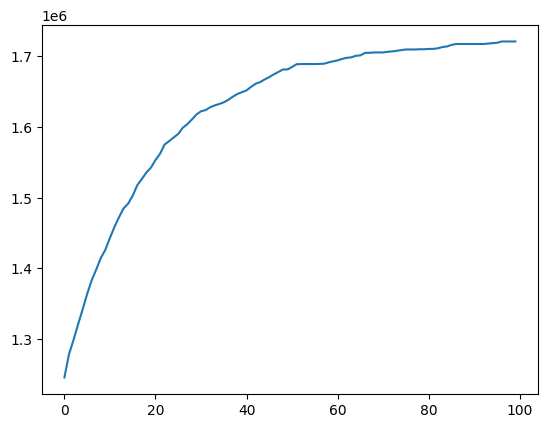

In [104]:
first_solution = benchmark_solution(find_first_solution, n_runs=10)
first_solution.total_value
tweaked_solution = first_solution
scores = []

for _ in tqdm(range(100)):
    tweaked_solution = benchmark_tweak(tweaked_solution, tweak_solution, n_runs=50)
    scores.append(tweaked_solution.total_value)

print(tweaked_solution.total_value)
plt.plot(scores)
plt.show()